In [1]:
# Third-party
from astropy.table import Table
import astropy.coordinates as coord
import astropy.units as u
from astropy.constants import G
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import numpy as np
plt.style.use('notebook.mplstyle')
%matplotlib inline
import corner
import emcee
from scipy.integrate import quad
from scipy.misc import logsumexp
import schwimmbad

In [2]:
# From John Brewer:
rv = -21.2 # km/s
rv_err = 0.1 # km/s

In [3]:
tgas = Table.read('../data/tgas.csv')
tgas['hd_id'] = ['240430', '240429']

coords = coord.SkyCoord(ra=tgas['ra']*u.deg, dec=tgas['dec']*u.deg, 
                        distance=1000./tgas['parallax']*u.pc)

In [4]:
def get_y_hat(row, names=['ra', 'dec', 'parallax', 'pmra', 'pmdec'], units=None):
    y = np.zeros(len(names))
        
    default_units = dict()
    default_units['ra'] = u.degree
    default_units['dec'] = u.degree
    default_units['parallax'] = u.mas
    default_units['pmra'] = u.mas/u.yr
    default_units['pmdec'] = u.mas/u.yr
    
    if units is None:
        units = [default_units[name] for name in names]
    
    for i,name in enumerate(names):
        y[i] = (row[name]*default_units[name]).to(units[i]).value
    
    return y

In [5]:
def get_cov(row, names=['ra', 'dec', 'parallax', 'pmra', 'pmdec'], units=None):
    
    default_err_units = dict()
    default_err_units['ra'] = u.mas
    default_err_units['dec'] = u.mas
    default_err_units['parallax'] = u.mas
    default_err_units['pmra'] = u.mas/u.yr
    default_err_units['pmdec'] = u.mas/u.yr
    
    if units is None:
        units = [default_err_units[name] for name in names]
    
    C = np.zeros((len(names), len(names)))

    # pre-load the diagonal
    for i,name in enumerate(names):
        full_name = "{}_error".format(name)
        C[i,i] = (row[full_name]*default_err_units[name]).to(units[i]).value**2

    for i,name1 in enumerate(names):
        for j,name2 in enumerate(names):
            if j <= i:
                continue
            full_name = "{}_{}_corr".format(name1, name2)
            u_old = default_err_units[name1]*default_err_units[name2]
            u_new = units[i]*units[j]
            C[i,j] = (row[full_name] * np.sqrt(C[i,i]*C[j,j]) * u_old).to(u_new).value
            C[j,i] = (row[full_name] * np.sqrt(C[i,i]*C[j,j]) * u_old).to(u_new).value
            
    return C

In [6]:
class ProbModel(object):
        
    def ln_posterior(self, pars):
        """ 
        Up to a normalization constant, the log of the posterior pdf is just 
        the sum of the log likelihood plus the log prior.
        """
        lnp = self.ln_prior(pars)
        if np.isinf(lnp): # short-circuit if the prior is infinite (don't bother computing likelihood)
            return lnp

        lnL = self.ln_likelihood(pars).sum()
        lnprob = lnp + lnL

        if np.isnan(lnprob):
            return -np.inf

        return lnprob
    
    def __call__(self, pars):
        return self.ln_posterior(pars)

## Hypothesis 1

The stars are a wide binary, drawn from a piecewise distribution:
$$
\begin{eqnarray}
p(a) &=& \begin{cases}
            a^{-1} & 100<a<3000~{\rm au}\\    
            a^{-1.6} & a \geq 3000~{\rm au}\\    
         \end{cases} 
\end{eqnarray}
$$

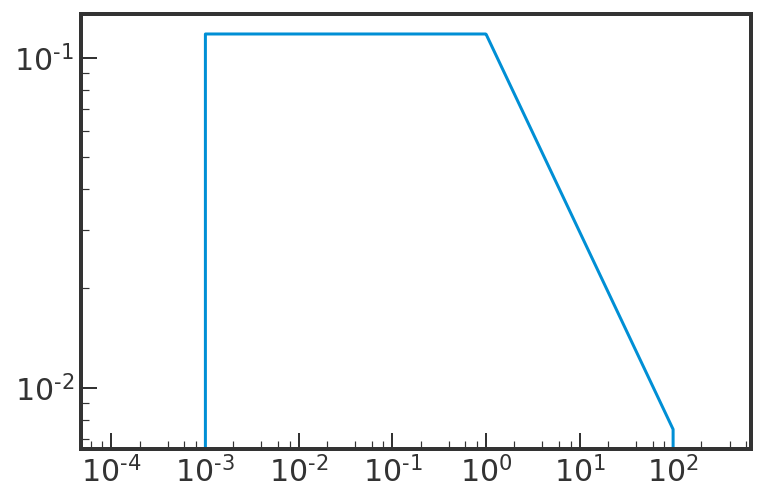

In [8]:
def p_a(a, a_min=1E-3, a_max=1E2, a_b=1.45E-2):
    if a < a_min or a > a_max:
        return 0.
    
    B = a_b**0.6
    Cinv = np.log(a_b) - np.log(a_min) + 5*B/3 * (a_b**-0.6 - a_max**-0.6)
    C = 1/Cinv
    
    if a < a_b:
        return C / a
        
    else:
        return C * B * a**-1.6
    
def ln_p_a(a, a_min=1E-3, a_max=1E2, a_b=1.45E-2):
    if a < a_min or a > a_max:
        return -np.inf
    
    B = a_b**0.6
    Cinv = np.log(a_b) - np.log(a_min) + 5*B/3 * (a_b**-0.6 - a_max**-0.6)
    C = 1/Cinv
    
    if a < a_b:
        return np.log(C) - np.log(a)
        
    else:
        return np.log(C) + np.log(B) - 1.6*np.log(a)
    
a = np.logspace(-4, 2.5, 1024)
plt.plot(a, a*np.array([p_a(aa, a_b=1.) for aa in a]), marker='')
plt.xscale('log')
plt.yscale('log')

res,_ = quad(p_a, 1E-3, 1E2)
assert np.allclose(res, 1.)

In [9]:
kmspc_to_masyr = 210.94953
masyr_to_kmspc = 1/kmspc_to_masyr

In [10]:
class Hypothesis1(ProbModel):
    
    def __init__(self, y_hat1, Cov1, y_hat2, Cov2, coord1, coord2, sigma_v=25.):
        """ 
        y_hat's should be: [parallax, pmra, pmdec, vr]
        units should be: [mas, mas/yr, mas/yr, km/s]
        """
        
        self.y_hat1 = np.array(y_hat1)
        self.Cov1 = Cov1
        self.Cinv1 = np.linalg.inv(Cov1)
        _,self.log_det_Cov1 = np.linalg.slogdet(2*np.pi*self.Cov1)
        
        self.y_hat2 = np.array(y_hat2)
        self.Cov2 = Cov2
        self.Cinv2 = np.linalg.inv(Cov2)
        _,self.log_det_Cov2 = np.linalg.slogdet(2*np.pi*self.Cov2)
        
        # sky coordinates
        self._sep = coord2.separation(coord1).radian
        self._cos_sep = np.cos(self._sep)
        
        self._uvec1 = np.array([np.cos(coord1.ra)*np.cos(coord1.dec),
                                np.sin(coord1.ra)*np.cos(coord1.dec),
                                np.sin(coord1.dec)])
        self._uvec2 = np.array([np.cos(coord2.ra)*np.cos(coord2.dec),
                                np.sin(coord2.ra)*np.cos(coord2.dec),
                                np.sin(coord2.dec)])
        
        # some assumed parameters
        self._G = G.to(u.pc/u.Msun*u.km**2/u.s**2).value
        self.mass = 2. # Msun
        self.sigma_v = sigma_v # km/s
    
    def unpack_pars(self, pars):
        """
        TODO: the right thing to do is to rotate (vra,vdec,vr) to (vx,vy,vz), but
            this is ok at the ~10 m/s level.
            
        pars are: [r1, vra1, vdec1, vr1, ln_a]
        units are: [pc, km/s, km/s, km/s, ln(pc)]
        
        output y's are: [parallax1, pmra1, pmdec1, vr1] 
        output y units are: [mas, mas/yr, mas/yr, km/s] 
        """
        r1, vra1, vdec1, vr1, ln_a = pars
        a = np.exp(ln_a)
        
        y1 = np.array([1000./r1, # mas
                       vra1 / r1 * kmspc_to_masyr, # mas/yr
                       vdec1 / r1 * kmspc_to_masyr, # mas/yr 
                       vr1]) # km/s
        
        # Do some trig to compute true r2 given sky positions, r1, a.
        # For generic separations, a, the solution has two roots: one where star 1 is 
        # closer and one where star 2 is closer.
        r2 = r1 * np.array([self._cos_sep + np.sqrt(self._cos_sep + (a/r1)**2 - 1.),
                            self._cos_sep - np.sqrt(self._cos_sep + (a/r1)**2 - 1.)]) # two roots
        
        # The magnitude of the velocity difference is set by the separation 
        # and an assumed mass
        dv_mag = np.sqrt(self._G * self.mass / a) # km/s
        
        # Assuming the pair are a bound 2-body system on a circular orbit, the 
        # difference in 3-space velocity vectors should be perpendicular to the 
        # separation vector, x2-x1. But we don't know if r1>r2 or r2>r1, and we
        # don't know if they are orbiting clockwise or counter-clockwise (on the 
        # sky), so we consider all 4 scenarios.
        x1 = r1 * self._uvec1
        x2 = r2[:,None] * self._uvec2[None] # (2, 3)
        dx = x2 - x1
        dv = np.cross(dx, x2)
        dv = dv_mag * dv / np.linalg.norm(dv, axis=-1)[:,None] # has shape (2, 3)
        
        # clockwise vs. counter-clockwise
        v1 = np.array([vra1, vdec1, vr1])
        v2 = np.zeros((2,2,3))
        v2[:,0] = v1 + dv
        v2[:,1] = v1 - dv
        
        y2 = np.zeros((2,2,4))
        y2[0,:,0] = 1000. / r2[0] # mas
        y2[1,:,0] = 1000. / r2[1] # mas
        y2[:,:,1:3] = v2[...,:2] / r2[:,None] * kmspc_to_masyr # mas/yr
        y2[:,:,3] = v2[...,2] # km/s

        return y1, y2.reshape(-1, 4) # flatten so that the 4 scenarios are (4, 4)
        
    def ln_likelihood(self, pars):
        y1,y2 = self.unpack_pars(pars)
        
        if np.any(np.isnan(y1)) or np.any(np.isnan(y2)):
            return -np.inf
        
        dy1 = (y1 - self.y_hat1)
        dy2 = (y2 - self.y_hat2)
        
        ln_p1 = -0.5 * self.log_det_Cov1 - 0.5 * (dy1.T @ self.Cinv1 @ dy1)
        
        ln_p2 = np.zeros(4)
        for i in range(4): # 4 scenarios (r1 > r2 vs. r2 > r1) x (+∆v vs. -∆v)
            ln_p2[i] = -0.5 * self.log_det_Cov2 - 0.5 * dy2[i].T @ self.Cinv2 @ dy2[i]
        return ln_p1 + logsumexp(ln_p2)

    def ln_prior(self, pars):
        # units: pc, km/s, km/s, km/s, pc
        r1, vra1, vdec1, vr1, ln_a = pars
        
        lp = 0.
        
        # Gaussian prior on velocity of star 1
        v = np.array([vra1, vdec1, vr1])
        lp += -0.5 * np.sum(v**2 / self.sigma_v**2 + np.log(2*np.pi*self.sigma_v**2))
        
        # Prior on separations is taken from TODO:
        # lp += ln_p_a(np.exp(ln_a))
        
        # HACK:
        # Assume uniform in lna out to wide separation:
        ln_amin = np.log(1E-3) # pc
        ln_amax = np.log(1E2) # pc
        if ln_a < ln_amin or ln_a > ln_amax:
            return -np.inf
        
        C = 1/(ln_amax-ln_amin)
        lp += np.log(C) # uniform
        
        # Uniform space density prior on distance to star 1
        r_lim = 300. # pc
        if r1 > r_lim:
            return -np.inf
        lp += np.log(3/r_lim**3) + 2*np.log(r1)
        
        return lp

In [11]:
yhat1 = get_y_hat(tgas[0], ['parallax', 'pmra', 'pmdec'])
yhat2 = get_y_hat(tgas[1], ['parallax', 'pmra', 'pmdec'])
yhat1 = np.concatenate((yhat1, [rv]))
yhat2 = np.concatenate((yhat2, [rv]))

Cov1 = np.zeros((4,4))
Cov1[:3,:3] = get_cov(tgas[0], ['parallax', 'pmra', 'pmdec'])
Cov1[3,3] = rv_err**2

Cov2 = np.zeros((4,4))
Cov2[:3,:3] = get_cov(tgas[1], ['parallax', 'pmra', 'pmdec'])
Cov2[3,3] = rv_err**2

In [12]:
H1 = Hypothesis1(yhat1, Cov1, yhat2, Cov2, coords[0], coords[1])

In [13]:
p0 = np.array([1000./yhat1[0], 4.74047*yhat1[1]/yhat1[0], 4.74047*yhat1[2]/yhat1[0], rv, np.log(0.6)])
H1.ln_likelihood(p0), H1.ln_prior(p0)

(3.2510895906110049, -23.703452737050966)

In [73]:
nwalkers = 64
ntemps = 128
betas = np.logspace(0, -8, ntemps)

In [74]:
%%time

p0 = np.array([1000./yhat1[0], 4.74047*yhat1[1]/yhat1[0], 4.74047*yhat1[2]/yhat1[0], rv, np.log(0.6)])
all_p0 = np.random.normal(p0, 1E-3*np.abs(p0), size=(ntemps, nwalkers, ndim))

ndim = len(p0)
with schwimmbad.MultiPool() as pool:
    sampler = emcee.PTSampler(ntemps, nwalkers, ndim, H1.ln_likelihood, H1.ln_prior,
                              betas=betas, pool=pool)

    sampler.reset()
    pos,_,_ = sampler.run_mcmc(all_p0, N=128)
    sampler.reset()
    pos,_,_ = sampler.run_mcmc(pos, N=1024)

/Users/adrian/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:132: RuntimeWarning: invalid value encountered in log
/Users/adrian/anaconda/lib/python3.5/site-packages/emcee/ptsampler.py:340: RuntimeWarning: invalid value encountered in less
  accepts = logrs < logpaccept
/Users/adrian/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:132: RuntimeWarning: invalid value encountered in log
/Users/adrian/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:132: RuntimeWarning: invalid value encountered in log
/Users/adrian/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:132: RuntimeWarning: invalid value encountered in log
/Users/adrian/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:57: RuntimeWarning: invalid value encountered in sqrt
/Users/adrian/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:58: RuntimeWarning: invalid value encountered in sqrt
/Users/adrian/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:57: Runti

CPU times: user 1min 6s, sys: 1.31 s, total: 1min 7s
Wall time: 7min 26s


In [75]:
# sampler.acor.shape

In [76]:
sampler.chain.shape

(128, 64, 1024, 5)

In [77]:
cmap = plt.get_cmap('magma')
norm = Normalize(0, ntemps)

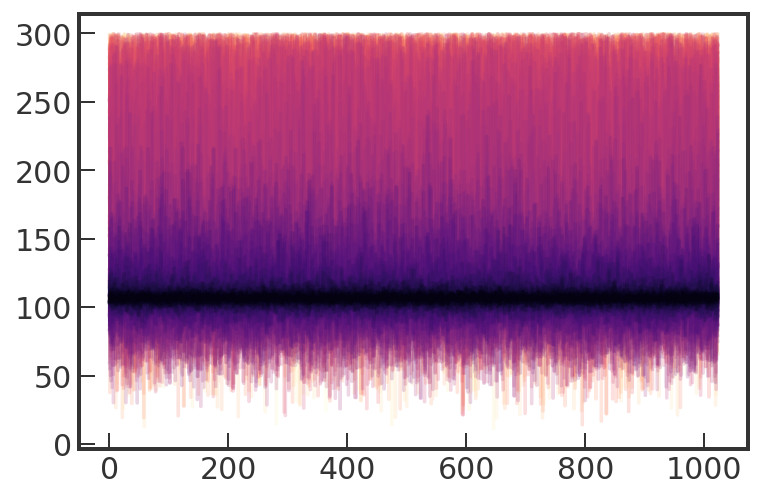

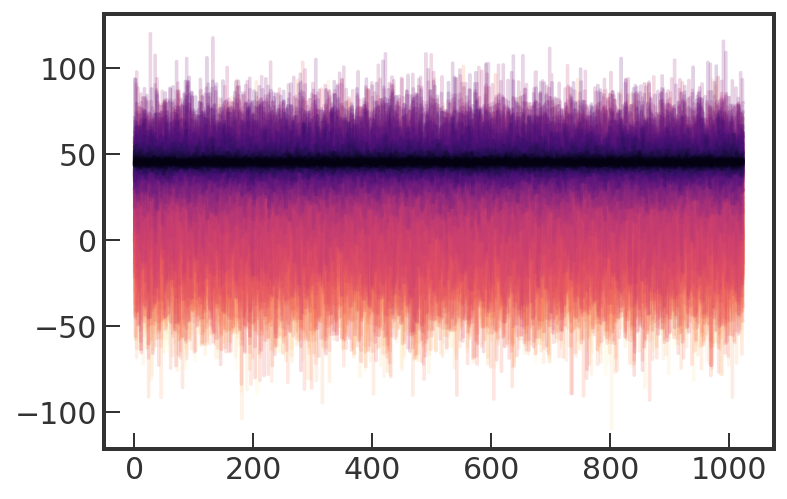

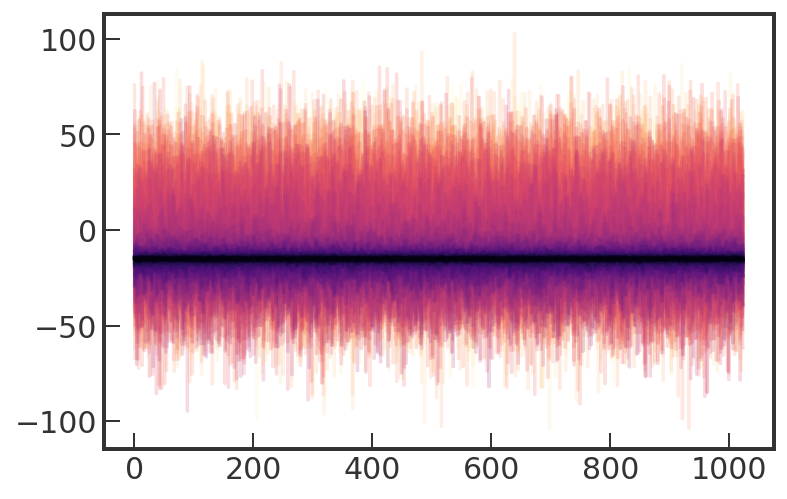

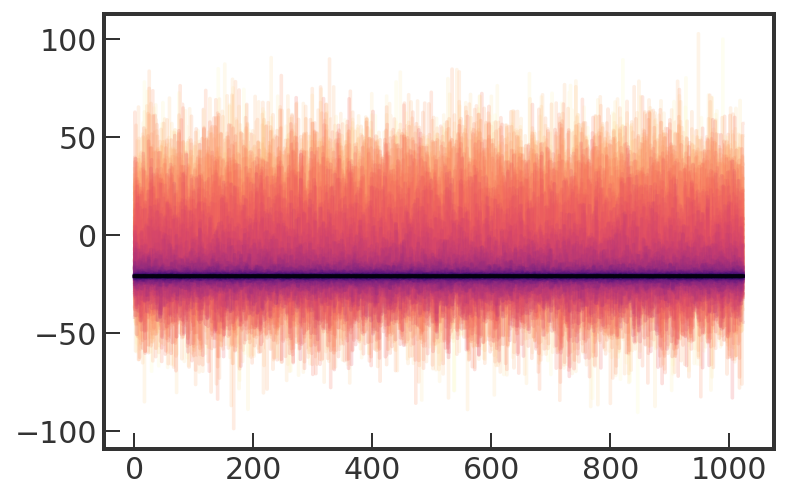

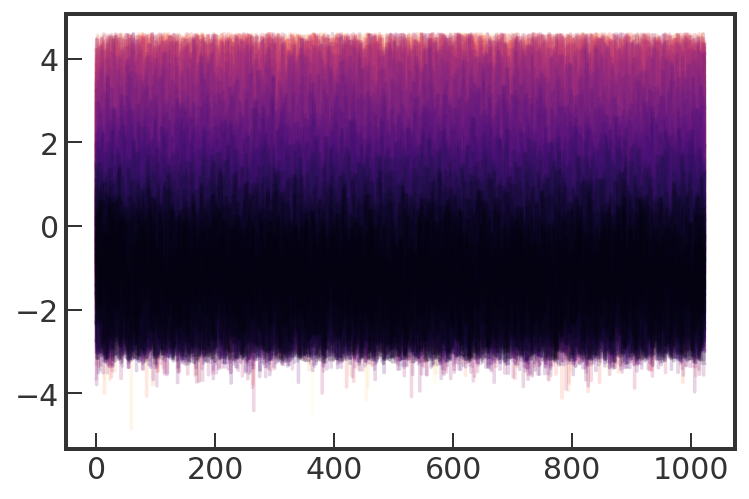

In [78]:
for k in range(ndim):
    plt.figure()
    for i in range(ntemps)[::-1]:
        color = cmap(norm(i))
        j = 0
        plt.plot(sampler.chain[i,j,:,k], marker='', alpha=0.2, 
                 drawstyle='steps-mid', color=color)

In [79]:
# for k in range(ndim):
#     plt.figure()
    
#     i = 0 # zero temperature?    
#     for j in range(nwalkers):
#         plt.plot(sampler.chain[i,j,:,k], marker='', alpha=0.2, 
#                  drawstyle='steps-mid', color='k')

In [80]:
ln_L1, dln_L1 = sampler.thermodynamic_integration_log_evidence(fburnin=0.)
ln_L1, dln_L1

(-18.877231253102909, 1.3707689455300738)

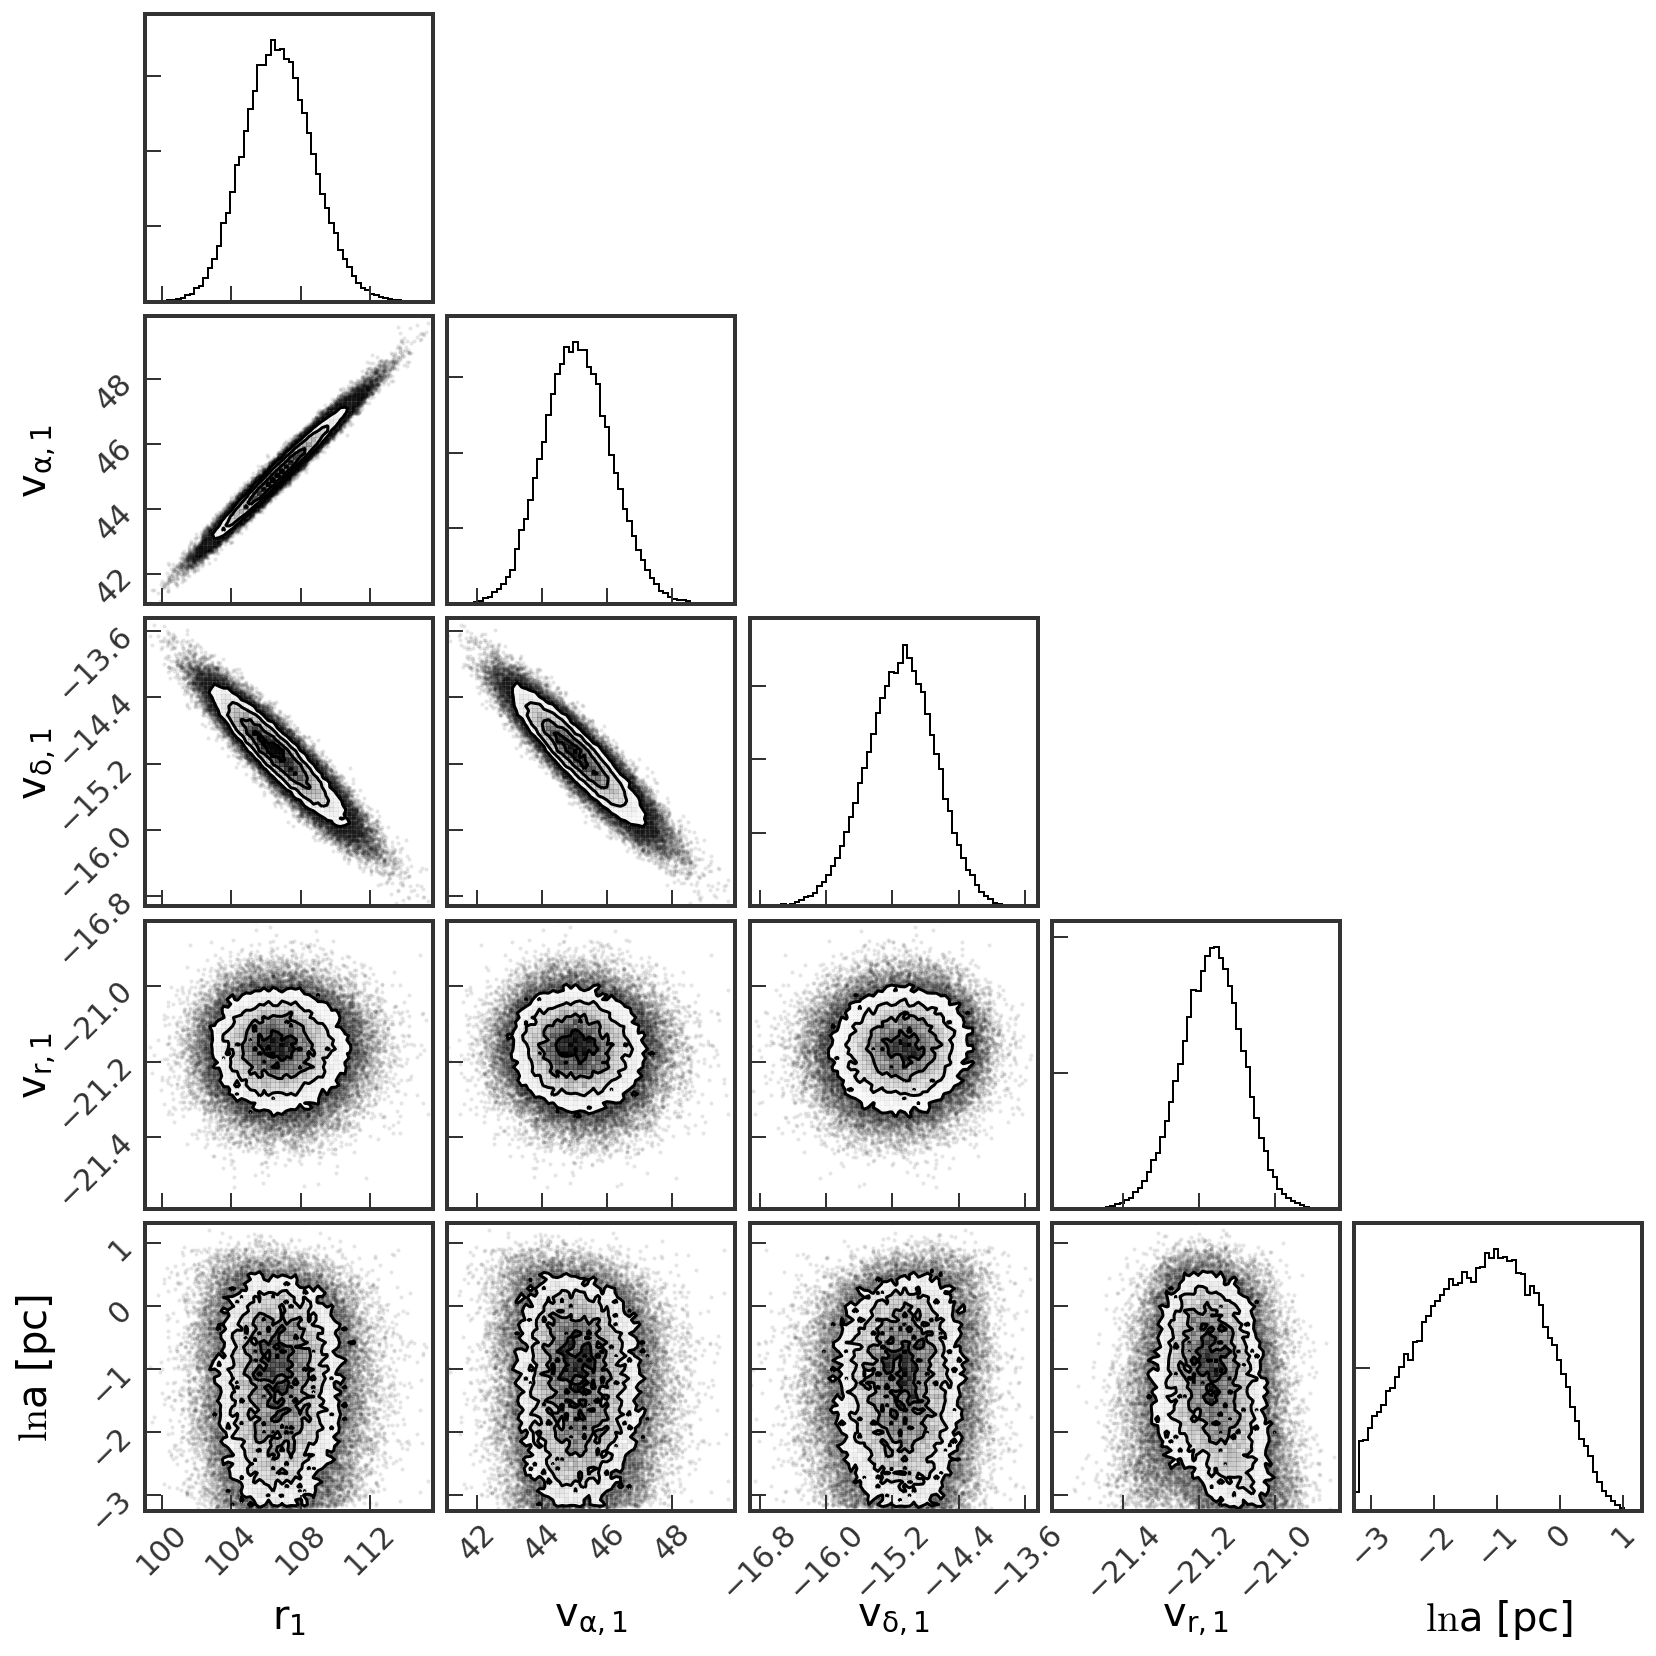

In [81]:
_ = corner.corner(sampler.flatchain[0], bins=64, 
                  labels=['$r_1$', r'$v_{\alpha,1}$', r'$v_{\delta,1}$', '$v_{r,1}$', r'$\ln a$ [pc]'])

## Hypothesis 2

The stars are independent draws from uniform space density prior and Gaussian.

In [82]:
class Hypothesis2(ProbModel):
    
    def __init__(self, y_hat, Cov, skycoord, sigma_v=25):
        """ 
        y_hat should be: [parallax, pmra, pmdec, vr]
        units should be: [mas, mas/yr, mas/yr, km/s]
        """
        
        self.y_hat = np.array(y_hat)
        self.Cov = Cov
        self.Cinv = np.linalg.inv(Cov)
        _,self.log_det_Cov = np.linalg.slogdet(2*np.pi*self.Cov)
        
        self.sigma_v = sigma_v # km/s
    
    def unpack_pars(self, pars):
        """
        pars are: [r, vra, vdec, vr]
        units are: [pc, km/s, km/s, km/s]
        
        output y: [parallax, pmra, pmdec, vr] 
        output y units: [mas, mas/yr, mas/yr, km/s] 
        """
        r, vra, vdec, vr = pars
        y = np.array([1000./r, # mas
                      vra/r * kmspc_to_masyr, # mas/yr
                      vdec/r * kmspc_to_masyr, # mas/yr
                      vr]) # km/s
        return y
        
    def ln_likelihood(self, pars):
        y = self.unpack_pars(pars)
        
        if np.any(np.isnan(y)):
            return -np.inf
        
        dy = (y - self.y_hat)        
        ln_p = -0.5 * self.log_det_Cov - 0.5 * (dy.T @ self.Cinv @ dy)
        return ln_p

    def ln_prior(self, pars):
        r, vra, vdec, vr = pars
        
        lp = 0.
        
        # Gaussian velocity prior
        v = np.array([vra, vdec, vr])
        lp += -0.5 * np.sum(v**2 / self.sigma_v**2 + np.log(2*np.pi*self.sigma_v**2))
        
        # Uniform space density
        r_lim = 300. # pc
        if r > r_lim:
            return -np.inf
        lp += np.log(3/r_lim**3) + 2*np.log(r)
        
        return lp

In [83]:
H2_1 = Hypothesis2(yhat1, Cov1, coords[0])
p0 = np.array([1000./yhat1[0], 4.74047*yhat1[1]/yhat1[0], 4.74047*yhat1[2]/yhat1[0], rv])
H2_1.ln_likelihood(p0), H2_1.ln_prior(p0)

(1.7238168120084392, -21.25998237936891)

In [84]:
samplers = []
for yhat,Cov,coo in zip([yhat1,yhat2], [Cov1,Cov2], coords):
    H2 = Hypothesis2(yhat, Cov, coo)
    
    p0 = np.array([1000./yhat[0], 4.74047*yhat[1]/yhat[0], 4.74047*yhat[2]/yhat[0], rv])
    ndim = len(p0)
    all_p0 = np.random.normal(p0, 1E-3*np.abs(p0), size=(ntemps, nwalkers, ndim))
    
    with schwimmbad.MultiPool() as pool:
        sampler = emcee.PTSampler(ntemps, nwalkers, ndim, H2.ln_likelihood, H2.ln_prior,
                                  betas=betas, pool=pool)

        sampler.reset()
        pos,_,_ = sampler.run_mcmc(all_p0, N=128)
        sampler.reset()
        pos,_,_ = sampler.run_mcmc(pos, N=1024)
    
    samplers.append(sampler)

/Users/adrian/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:54: RuntimeWarning: invalid value encountered in log
/Users/adrian/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:54: RuntimeWarning: invalid value encountered in log
/Users/adrian/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:54: RuntimeWarning: invalid value encountered in log
/Users/adrian/anaconda/lib/python3.5/site-packages/emcee/ptsampler.py:340: RuntimeWarning: invalid value encountered in less
  accepts = logrs < logpaccept
/Users/adrian/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:54: RuntimeWarning: invalid value encountered in log
/Users/adrian/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:54: RuntimeWarning: invalid value encountered in log
/Users/adrian/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:54: RuntimeWarning: invalid value encountered in log
/Users/adrian/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:54: RuntimeWarn

In [85]:
ln_L2 = 0
dln_L2 = 0
for sampler in samplers:
    _a,_b = sampler.thermodynamic_integration_log_evidence()
    ln_L2 += _a
    dln_L2 = np.sqrt(dln_L2**2 + _b**2)

In [86]:
ln_L1 - ln_L2

18.725182058066306

## Estimate BIC

In [490]:
from scipy.optimize import minimize

In [491]:
p0 = np.array([1000./yhat1[0], 4.74047*yhat1[1]/yhat1[0], 4.74047*yhat1[2]/yhat1[0], rv, np.log(0.6)])
res = minimize(lambda *args: -H1.ln_likelihood(*args), x0=p0, method='L-BFGS-B')
assert res.success

H1.ln_likelihood(res.x)

3.7078022808581692

In [492]:
H2s = []
p0s = []
for yhat,Cov,coo in zip([yhat1,yhat2], [Cov1,Cov2], coords):
    H2 = Hypothesis2(yhat, Cov, coo)
    H2s.append(H2)
    
    p0 = np.array([1000./yhat[0], 4.74047*yhat[1]/yhat[0], 4.74047*yhat[2]/yhat[0], rv])
    p0s.append(p0)

p0 = np.concatenate(p0s)
    
res = minimize(lambda p: -H2s[0].ln_likelihood(p[:4])-H2s[1].ln_likelihood(p[4:]), 
               x0=p0, method='L-BFGS-B')
assert res.success

H2s[0].ln_likelihood(res.x[:4]) + H2s[1].ln_likelihood(res.x[4:])

3.405464378786359

In [180]:
import vegas

In [181]:
integ = vegas.Integrator([(102, 109), 
                          (40, 50), (-20, -10), (-22.2, -20.2), 
                          (0,1)])

In [102]:
def vegas_derp(p0):
    return np.exp(H1.ln_likelihood(p0) + H1.ln_prior(p0))

In [104]:
result = integ(vegas_derp, nitn=10, neval=100000)
print(result.summary())
print('result = %s    Q = %.2f' % (result, result.Q))

itn   integral        wgt average     chi2/dof        Q
-------------------------------------------------------
  1   6.465(95)e-10   6.465(95)e-10       0.00     1.00
  2   6.538(45)e-10   6.525(40)e-10       0.48     0.49
  3   6.632(59)e-10   6.559(33)e-10       1.35     0.26
  4   6.616(47)e-10   6.578(27)e-10       1.22     0.30
  5   7.11(42)e-10    6.581(27)e-10       1.32     0.26
  6   6.702(50)e-10   6.608(24)e-10       1.98     0.08
  7   6.75(11)e-10    6.615(23)e-10       1.93     0.07
  8   6.718(71)e-10   6.625(22)e-10       1.93     0.06
  9   6.628(37)e-10   6.626(19)e-10       1.69     0.10
 10   6.658(38)e-10   6.632(17)e-10       1.57     0.12

result = 6.632(17)e-10    Q = 0.12
